# Random Forest Regression

In [1]:
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
x_tr=pd.read_csv('../X_train.csv', sep=',')
y_tr=pd.read_csv('../y_train.csv', sep=',')
x_te=pd.read_csv('../X_test.csv', sep=',')

# Initial empty prediction dataframe
index = np.arange(len(x_te.iloc[:,0]))
columns = ["Id"]
rows = len(x_te.iloc[:,0])
data = np.arange(rows, dtype=int)
prediction = pd.DataFrame(data, columns=columns)

# Ignore deprecation warnings (makes results hard to read)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [26]:
#RFR pipeline (l1 regularisation)

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# Scale twice, as poly features will return values that need to be rescaled
pipe = Pipeline([("scaler1", StandardScaler()),
                  ("poly", PolynomialFeatures(degree=3)),
                  ("scaler2", StandardScaler()),
                  ("rfr", RandomForestRegressor(bootstrap=True, criterion="mse"))
                 ])

# lower step size gives better results, but increases computation time
md_step_size = 5
ne_step_size = 9
# Perform a grid search to find the best max_depth & n_estimators according to neg_mean_absolute_error scoring
param_grid = {
    'rfr__max_depth': np.arange(1,20,md_step_size),
    'rfr__n_estimators': np.arange(1,100,ne_step_size)
}
search = GridSearchCV(pipe, param_grid, cv=5, error_score="raise", scoring="neg_mean_squared_error")
print("Best Params:" + str(search.fit(x_tr, y_tr["PRP"]).best_params_))

model = search.fit(x_tr, y_tr["PRP"]).best_estimator_

prediction["PRP"] = np.around(model.predict(x_te)).astype(int)
print(prediction.to_string(index=False))
prediction.to_csv("n_rfr_results.csv", index=False)
print(model.score(x_tr, y_tr["PRP"])) # R2 scoring for good measure

Best Params:{'rfr__max_depth': 6, 'rfr__n_estimators': 64}
 Id  PRP
  0   45
  1  173
  2   17
  3  335
  4   57
  5   19
  6   62
  7   35
  8   66
  9   32
 10  159
 11   18
 12  297
 13   58
 14  166
 15   25
 16   31
 17   38
 18   29
 19  136
 20   84
 21   21
 22   62
 23   19
 24  173
 25  115
 26   68
 27  518
 28   38
 29  271
 30   94
 31   18
 32   60
 33  186
 34   39
 35  883
 36   36
 37  518
 38   29
 39   32
 40   94
0.9767759661414629


# Experiments

In [27]:
# Testing the impact of bootstrap and scoring criterion

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def get_pipe(bootstrap, criterion):
    pipe = Pipeline([("scaler1", StandardScaler()),
                      ("poly", PolynomialFeatures(degree=3)),
                      ("scaler2", StandardScaler()),
                      ("rfr", RandomForestRegressor(bootstrap=bootstrap, criterion="mse"))
                     ])
    return pipe
    
model = get_pipe(True, "mse").fit(x_tr, y_tr["PRP"])
print(model.score(x_tr, y_tr["PRP"]))

# Overfit when false
model = get_pipe(False, "mse").fit(x_tr, y_tr["PRP"])
print(model.score(x_tr, y_tr["PRP"]))

model = get_pipe(True, "mae").fit(x_tr, y_tr["PRP"])
print(model.score(x_tr, y_tr["PRP"]))

model = get_pipe(False, "mae").fit(x_tr, y_tr["PRP"])
print(model.score(x_tr, y_tr["PRP"]))

0.9779433223853428
0.997109126616774
0.9524486233122177
0.997109126616774


In [67]:
# Plot CV results

from scipy.interpolate import make_interp_spline, BSpline

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score'] * -1
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score'] * -1
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(figsize=(12, 8))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        # Smooth curves for better plotting
        grid_param_1 = np.array(grid_param_1)
        xnew = np.linspace(grid_param_1.min(), grid_param_1.max(), 100) 
        spl = make_interp_spline(grid_param_1, scores_mean[idx,:], k=3)
        power_smooth = spl(xnew)
                                 
        ax.plot(xnew, power_smooth, label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=18,)
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel('CV Average MSE', fontsize=14)
    ax.legend(loc="best", fontsize=10)
    ax.grid('on')


Best Params:{'rfr__max_depth': 10, 'rfr__n_estimators': 30}
 Id  PRP
  0   36
  1  196
  2   14
  3  440
  4   59
  5   20
  6   53
  7   19
  8   51
  9   37
 10   95
 11   16
 12  273
 13   61
 14  171
 15   31
 16   25
 17   54
 18   34
 19  142
 20   81
 21   11
 22   47
 23   21
 24  184
 25  121
 26   64
 27  470
 28   34
 29  234
 30  100
 31   15
 32   63
 33  183
 34   34
 35  486
 36   40
 37  470
 38   25
 39   39
 40  100
0.9147649357197771


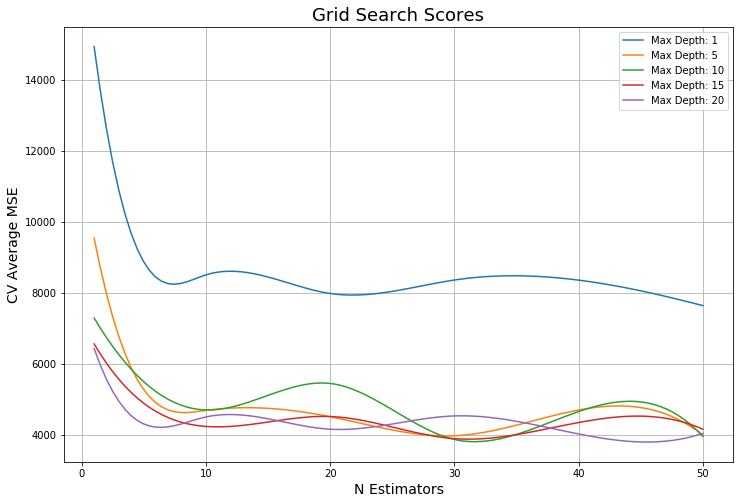

In [71]:
# Varying max_depth and n_estimators

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

pipe = Pipeline([("scaler1", StandardScaler()),
                  ("poly", PolynomialFeatures(degree=3)),
                  ("scaler2", StandardScaler()),
                  ("rfr", RandomForestRegressor(bootstrap=True, criterion="mse"))
                 ])

# lower step size gives better results, but increases computation time
n_estimators = [1, 5, 10, 20, 30, 40, 50]
max_depth = [1, 5, 10, 15, 20]
# Perform a grid search to find the best max_depth & n_estimators according to neg_mean_absolute_error scoring
param_grid = {
    'rfr__max_depth': max_depth,
    'rfr__n_estimators': n_estimators
}
search = GridSearchCV(pipe, param_grid, cv=5, error_score="raise", scoring="neg_mean_squared_error")
print("Best Params:" + str(search.fit(x_tr, y_tr["PRP"]).best_params_))

plot_grid_search(search.cv_results_, n_estimators, max_depth, 'N Estimators', 'Max Depth')

model = search.fit(x_tr, y_tr["PRP"]).best_estimator_

prediction["PRP"] = np.around(model.predict(x_te)).astype(int)
print(prediction.to_string(index=False))
prediction.to_csv("n_rfr_results.csv", index=False)
print(model.score(x_tr, y_tr["PRP"])) # R2 scoring for good measure